Imports
--

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
import joblib
import streamlit as st

Data ([Source](https://beta.data.gov.sg/datasets?query=polyclinic&resultId=d_5d5508f1c954f5630d7b3aa7875d01f9))
---

In [2]:
# Load data
df = pd.read_csv('../data/question2/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv')
print(df.shape)
df.head()

(2557, 3)


,epi_week,disease,no._of_cases
0,2012-W01,Acute Upper Respiratory Tract infections,2932
1,2012-W01,Acute Conjunctivitis,120
2,2012-W01,Acute Diarrhoea,491
3,2012-W01,Chickenpox,18
4,2012-W02,Acute Upper Respiratory Tract infections,3189


Preparation
---

In [3]:
# Confirm no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   epi_week      2557 non-null   object
 1   disease       2557 non-null   object
 2   no._of_cases  2557 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 60.1+ KB


In [4]:
# Check unique diseases in dataset
df['disease'].value_counts()

disease
Acute Upper Respiratory Tract infections    574
Acute Conjunctivitis                        574
Acute Diarrhoea                             574
Chickenpox                                  574
HFMD                                        261
Name: count, dtype: int64

- We'll focus on only the Acute diseases for modleing, to try and predict the _average_ number of patients for a given disease.
- To model the "average daily number of cases" instead of just the "number of cases (available in the dataset)," we'll convert the weekly total cases (our current data granularity) into daily averages by dividing the weekly totals by 7 (the number of days in a week).

In [5]:
# Filter to exclude diseases not required for modeling
df = df[~df['disease'].isin(['Chickenpox', 'HFMD'])]

# Verify filter
print(df.shape)
df['disease'].value_counts()

(1722, 3)


disease
Acute Upper Respiratory Tract infections    574
Acute Conjunctivitis                        574
Acute Diarrhoea                             574
Name: count, dtype: int64

In [6]:
# Check for any duplicates in "epi_week" for each disease
duplicates = df[df.duplicated(subset=['disease', 'epi_week'], keep=False)]

# Display the rows with duplicates
print(duplicates)

Empty DataFrame
Columns: [epi_week, disease, no._of_cases]
Index: []


__Conclusions:__ 
- No missing values, and no duplicate periods within each disease.

In [7]:
# Convert "epi_week" to datetime with error handling
df['epi_week'] = pd.to_datetime(df['epi_week'] + '-1', format='%Y-W%W-%w', errors='coerce')

# Create a new column for "average_cases" for modeling
df['average_cases'] = df['no._of_cases'] / 7

# Examine conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1722 entries, 0 to 2554
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   epi_week       1722 non-null   datetime64[ns]
 1   disease        1722 non-null   object        
 2   no._of_cases   1722 non-null   int64         
 3   average_cases  1722 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 67.3+ KB


In [8]:
# Set index to be the epi_week column 
df = df.set_index('epi_week')

# Ascending sort on the index to maintain chronological order
df = df.sort_index()

# Confirm operations
print(df.shape)
df.head()

(1722, 3)


,disease,no._of_cases,average_cases
epi_week,,,
2012-01-02,Acute Upper Respiratory Tract infections,2932,418.857143
2012-01-02,Acute Conjunctivitis,120,17.142857
2012-01-02,Acute Diarrhoea,491,70.142857
2012-01-09,Acute Upper Respiratory Tract infections,3189,455.571429
2012-01-09,Acute Conjunctivitis,114,16.285714


EDA
---

### Visual Trend Inspection

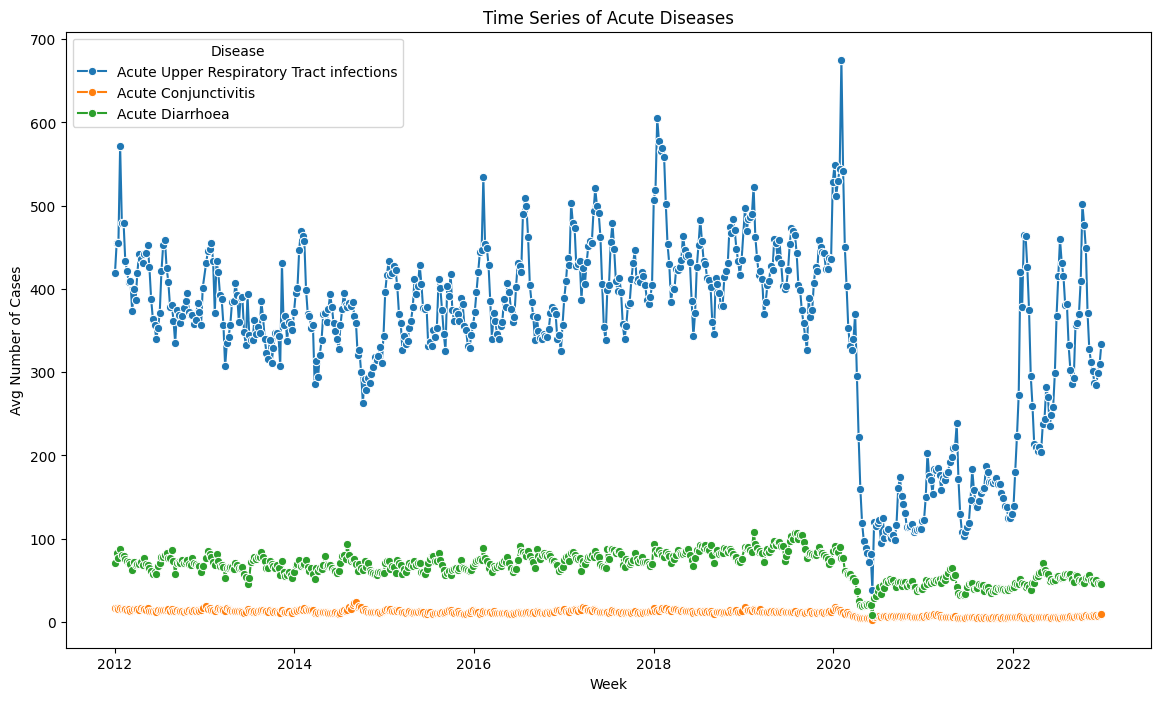

In [9]:
# Plot the time series for each acute disease 
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='average_cases', hue='disease', marker='o')
plt.title('Time Series of Acute Diseases')
plt.xlabel('Week')
plt.ylabel('Avg Number of Cases')
plt.legend(title='Disease')
plt.show()

__Conclusions:__
- "Acute Upper Respiratory Tract infections" has the highest number of cases.
- Some seasonal pattern observed.
- Pandemic impact noted across all diseases between 2020-2021.

### Seasonal Decomposition & Stationarity Test
- To decompose  time series into trend, seasonal, and residual components.
- Augmented Dickey-Fuller (ADF) Test to confirm that the residual component (the noise) of the time series is stationary.


Decomposition and ADF Test for Acute Upper Respiratory Tract infections


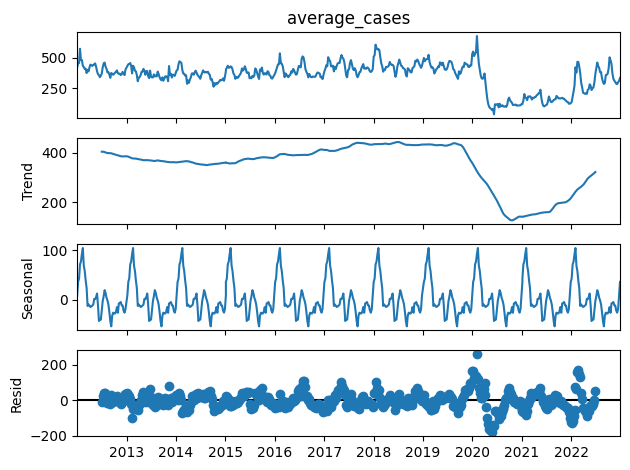

ADF Statistic: -7.1636
p-value: 0.0000
Critical Values:
   1%: -3.4433
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.

Decomposition and ADF Test for Acute Conjunctivitis


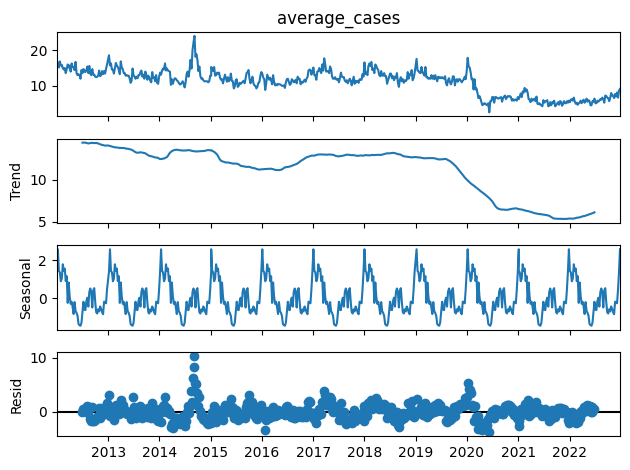

ADF Statistic: -7.0547
p-value: 0.0000
Critical Values:
   1%: -3.4434
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.

Decomposition and ADF Test for Acute Diarrhoea


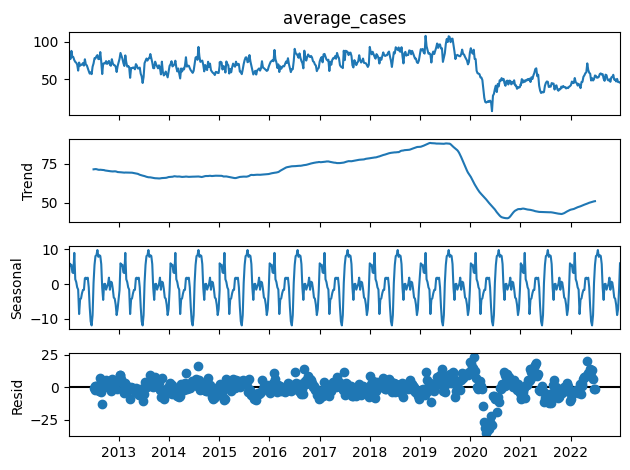

ADF Statistic: -5.2398
p-value: 0.0000
Critical Values:
   1%: -3.4434
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.



In [10]:
# Perform seasonal decomposition and ADF test
def seasonal_decompose_and_adf(series, period=52):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    decomposition.plot()
    plt.tight_layout()
    plt.show()

    # ADF test on residuals
    residuals = decomposition.resid.dropna()
    adf_result = adfuller(residuals)
    
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if adf_result[1] < 0.05:
        print("The residuals are stationary.\n")
    else:
        print("The residuals are not stationary. Differencing might be needed.\n")
    
    return decomposition

# Dictionary to hold decompositions for each disease
decompositions = {}

# Separate data for each disease and perform seasonal decomposition and ADF test
for disease in df['disease'].unique():
    disease_data = df[df['disease'] == disease]['average_cases']
    print(f"Decomposition and ADF Test for {disease}")
    decompositions[disease] = seasonal_decompose_and_adf(disease_data)

__Conclusions__:
- **Seasonality**: All diseases show clear seasonal patterns, which is captured well by the additive model.
- **Trend**: All diseases exhibit a notable drop in cases between 2020-2021, likely due to the impact of the pandemic.
- **Residuals**: Larger residuals during the pandemic period.
- The residuals across the 3 acute diseases are stationary. We'll proceed with modeling the average number of cases for each disease over time.

Note: Multiplicative Decomposition is not performed based on visual inspection from the additive plots, where the seasonal variations appear to be constant and not scaling with trend.

Machine Learning - Time Series Forecasting
---
- Given the small size of the data - Auto-ARIMA models (`pmdarima` has been used for modeling as they are known to perform well despite smaller sample sizes.)
- Based on online research, the three acute diseases are not directly caused by COVID-19. However, the COVID-19 pandemic could have influenced the incidence and reporting of these diseases through various indirect mechanisms. As such, the downstream modeling is aimed to account for the full impact and capture the complete dynamics of the provided time series data and thus the pandemic period has not been excluded. 

### Train-test split

In [11]:
# Split data into training and testing sets based on week 26 of 2022
train_end_date = pd.to_datetime('2022-07-03')  

train_data = {}
test_data = {}

for disease in df['disease'].unique():
    disease_data = df[df['disease'] == disease]['average_cases']
    train_data[disease] = disease_data[disease_data.index <= train_end_date]
    test_data[disease] = disease_data[disease_data.index > train_end_date]

### Plot ACF to confirm seasonal component 'm' for SARIMA

ACF for Acute Upper Respiratory Tract infections


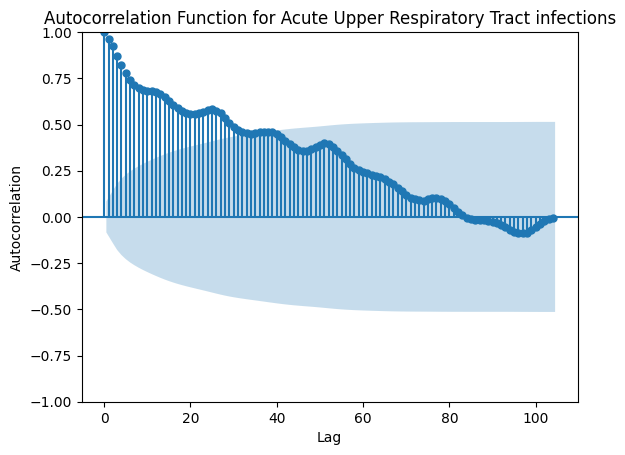

ACF for Acute Conjunctivitis


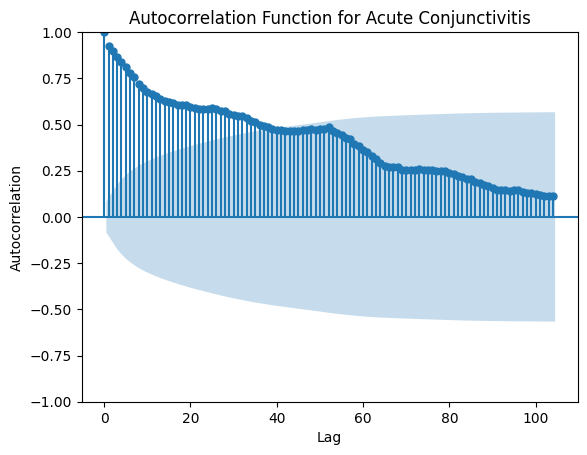

ACF for Acute Diarrhoea


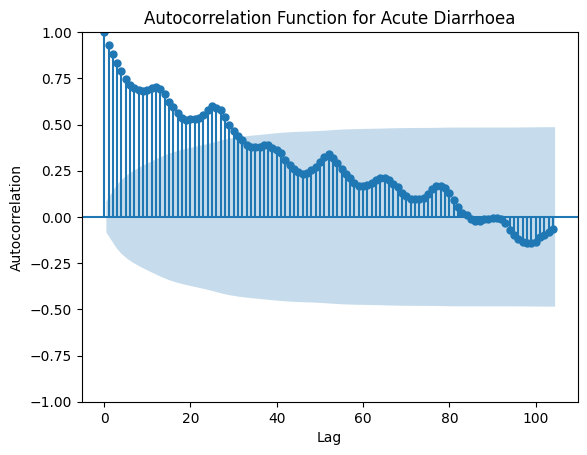

In [12]:
# Plot ACF for each disease to confirm seasonal parameter `m`
for disease in df['disease'].unique():
    print(f"ACF for {disease}")
    plot_acf(train_data[disease], lags=104)  # Plot ACF up to 104 lags (2 years of weekly data)
    plt.title(f'Autocorrelation Function for {disease}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

__Conclusions:__
- From ACF plots, we can deduce significant peak around lag `52`, suggesting annual seasonality for weekly data which is reasonable given our data's weekly granularity Year on Year. 

### Model Fitting

In [13]:
# Function to fit SARIMA and forecast using pmdarima with optimized parameters
def fit_sarima(train, test, m=52):
    sarima_model = auto_arima(
        train,
        start_p=0,
        max_p=2,  # Reduced max_p
        start_q=0,
        max_q=2,  # Reduced max_q
        start_P=0,
        max_P=2,  # Reduced max_P
        start_Q=0,
        max_Q=2,  # Reduced max_Q
        seasonal=True,
        m=m,
        stepwise=True,
        trace=True,
        random_state=20,
        suppress_warnings=True,
        n_fits=20,  # Reduced n_fits
        maxiter=10,  # Limited number of iterations
        approximation=True,  # Use approximation methods
        test='kpss'  # Use KPSS test for stationarity
    )
    forecast = sarima_model.predict(n_periods=len(test))
    return forecast, sarima_model

In [14]:
# Apply SARIMA to each disease
sarima_forecasts = {}
sarima_models = {}
for disease in df['disease'].unique():
    print(f"Fitting SARIMA for {disease}")
    sarima_forecasts[disease], sarima_models[disease] = fit_sarima(train_data[disease], test_data[disease], m=52)

Fitting SARIMA for Acute Upper Respiratory Tract infections
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=5284.482, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=5267.086, Time=1.68 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=5270.732, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5282.487, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=5285.235, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=5261.888, Time=8.21 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=11.08 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=5259.963, Time=9.98 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=5265.108, Time=2.76 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=16.38 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=5261.940, Time=10.01 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1739.453, Time=1.56 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1733.705, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1807.727, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1748.127, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1728.186, Time=2.43 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1731.186, Time=1.51 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=11.92 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=11.88 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=1732.090, Time=7.85 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=1730.519, Time=8.15 sec
 ARIMA(0,1,1)(2,0,2)[52] intercept   : AIC=inf, Time=14.64 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=1789.966, Time=2.20 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=1731.341, Time=3.15 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=1729.932, Time=3.09 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1736.302, Time=2.48 sec
 ARIMA(

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3492.106, Time=2.21 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3503.465, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3552.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3539.586, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=11.05 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=3506.374, Time=1.93 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=3452.814, Time=12.15 sec
 ARIMA(1,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=14.14 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=3452.958, Time=12.79 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=9.73 sec
 ARIMA(2,1,0)(2,0,1)[52] intercept   : AIC=3447.290, Time=15.67 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=16.03 sec
 ARIMA(2,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=16.27 sec
 ARIMA(2,1,0)(1,0,0)[52

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model Forecast & Evaluation

In [15]:
# Function to calculate MAPE
def calculate_mape(actual, forecast):
    return mean_absolute_percentage_error(actual, forecast) * 100

# Function to calculate MAPE and plot forecasts
def plot_forecast(y_train, y_test, y_pred, title):
    plt.figure(figsize=(15, 8))
    plt.plot(y_train.index, y_train, color='blue', label='Training')
    plt.plot(y_test.index, y_test, color='orange', label='Actual', alpha=0.7)
    plt.plot(y_test.index, y_pred, color='green', label='Forecast', alpha=0.9, ls='--')
    
    mape = calculate_mape(y_test, y_pred)
    plt.title(f'{title}\n MAPE: {mape:.2f}', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Avg Number of Cases')
    plt.legend()
    plt.show()

Acute Upper Respiratory Tract infections - SARIMA MAPE: 15.89%

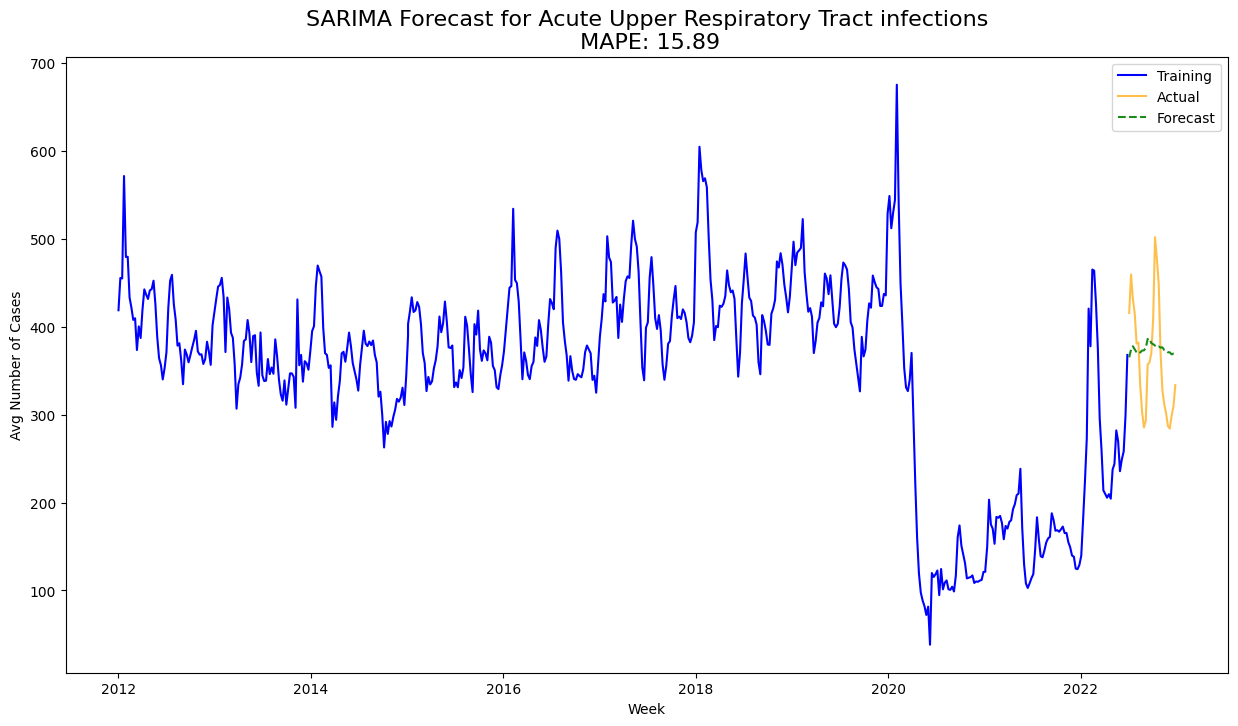

Acute Conjunctivitis - SARIMA MAPE: 13.81%


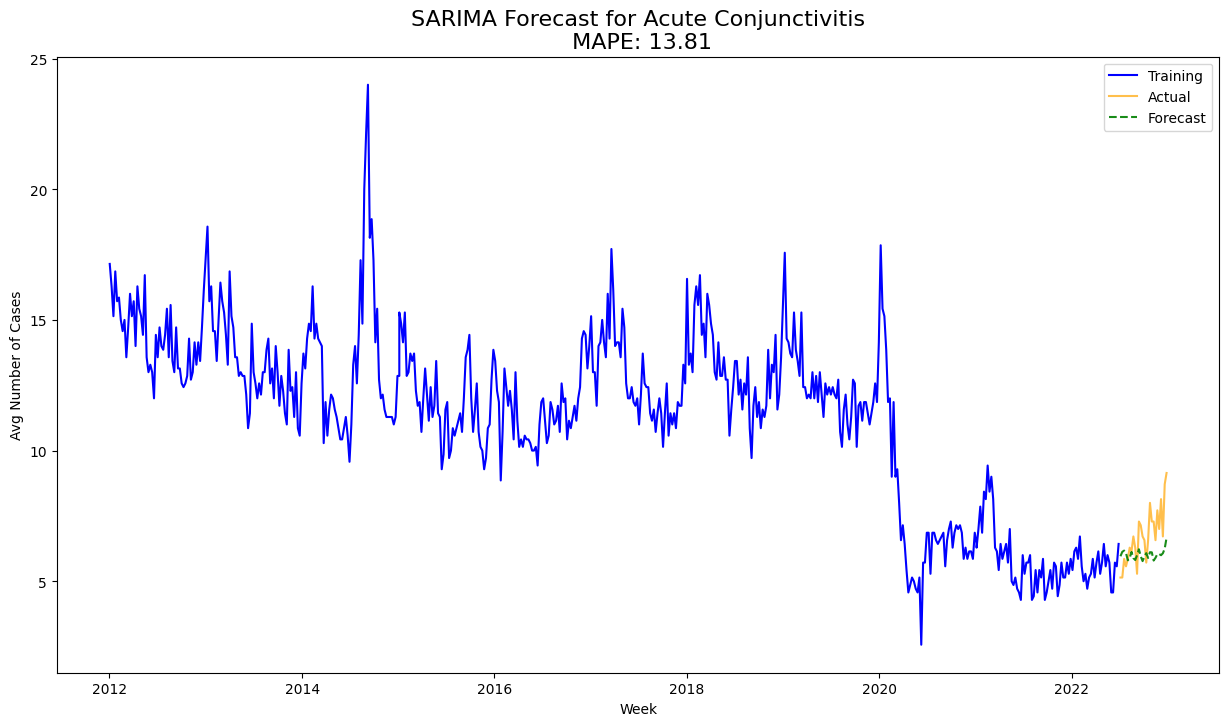

Acute Diarrhoea - SARIMA MAPE: 5.62%


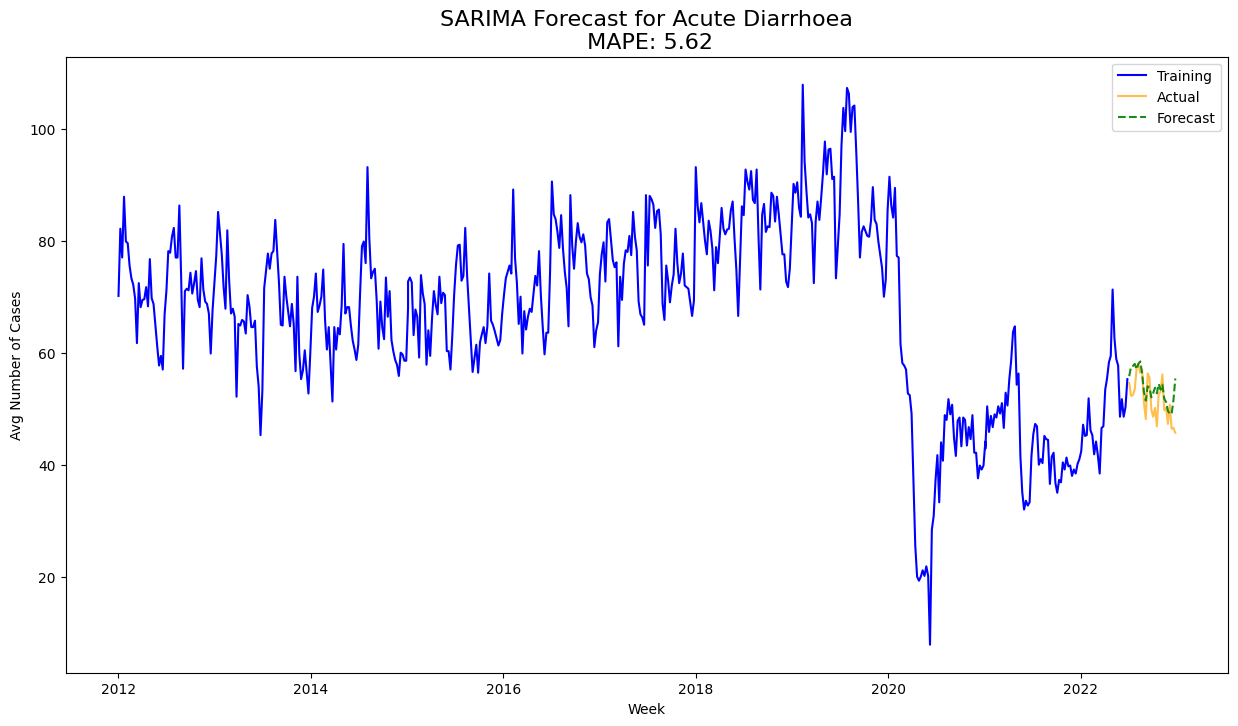

In [16]:
# Evaluate SARIMA forecasts
for disease in df['disease'].unique():
    sarima_mape = calculate_mape(test_data[disease], sarima_forecasts[disease])
    
    print(f"{disease} - SARIMA MAPE: {sarima_mape:.2f}%")
      
    # Plot the forecast vs actual for SARIMA
    plot_forecast(train_data[disease], test_data[disease], sarima_forecasts[disease], f'SARIMA Forecast for {disease}')

__Conclusions:__
- The MAPE for 1 of the disease: `Acute Diarrhoea` was lower than 10%, indicating good fit and forecast accuracy. 
- The other 2 diseases had MAPEs above 10% but below 20%, indicating moderate forecast accuracy.

#### Non-pandemic Period Evaluation
- Reevaluate removing pandemic period to check for improvement in model performance.
- Focus on `Acute Upper Respiratory Tract infections` with the most volume of cases but moderate forecast accuracy from previous segment.

In [17]:
# Define the pandemic period
pandemic_start_date = pd.to_datetime('2020-03-01') # Globally recognized start date of pandemic
pandemic_end_date = pd.to_datetime('2021-12-31')

# Filter out the pandemic period
df_no_pandemic = df[~((df.index >= pandemic_start_date) & (df.index <= pandemic_end_date))]

# Split data into training and testing sets based on week 26 of 2022, excluding pandemic period
train_end_date = pd.to_datetime('2022-07-03')
train_data = {}
test_data = {}

# Narrow to one disease for reevaluation
acute_disease = ['Acute Upper Respiratory Tract infections']

In [18]:
# Redefine train and test data
for disease in acute_disease:
    disease_data = df_no_pandemic[df_no_pandemic['disease'] == disease]['average_cases']
    train_data[disease] = disease_data[disease_data.index <= train_end_date]
    test_data[disease] = disease_data[disease_data.index > train_end_date]

# Apply SARIMA 
sarima_forecasts_rev = {}
sarima_models_rev = {}

for disease in acute_disease:
    print(f"Fitting SARIMA for {disease}")
    sarima_forecasts_rev[disease], sarima_models_rev[disease] = fit_sarima(train_data[disease], test_data[disease])

Fitting SARIMA for Acute Upper Respiratory Tract infections
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=4449.017, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=4432.296, Time=2.60 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=4437.938, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=4447.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=4450.782, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=4421.499, Time=11.67 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=4420.568, Time=13.30 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,1,0)(2,0,2)[52] intercept   : AIC=4422.740, Time=13.39 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=4419.658, Time=10.47 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=4428.914, Time=13.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=4437.933, Time=2.25 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=4419.497, Time=8.51 sec
 ARIMA(0,1,0)(0,0,2)[52] i

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Acute Upper Respiratory Tract infections - SARIMA MAPE: 22.74%


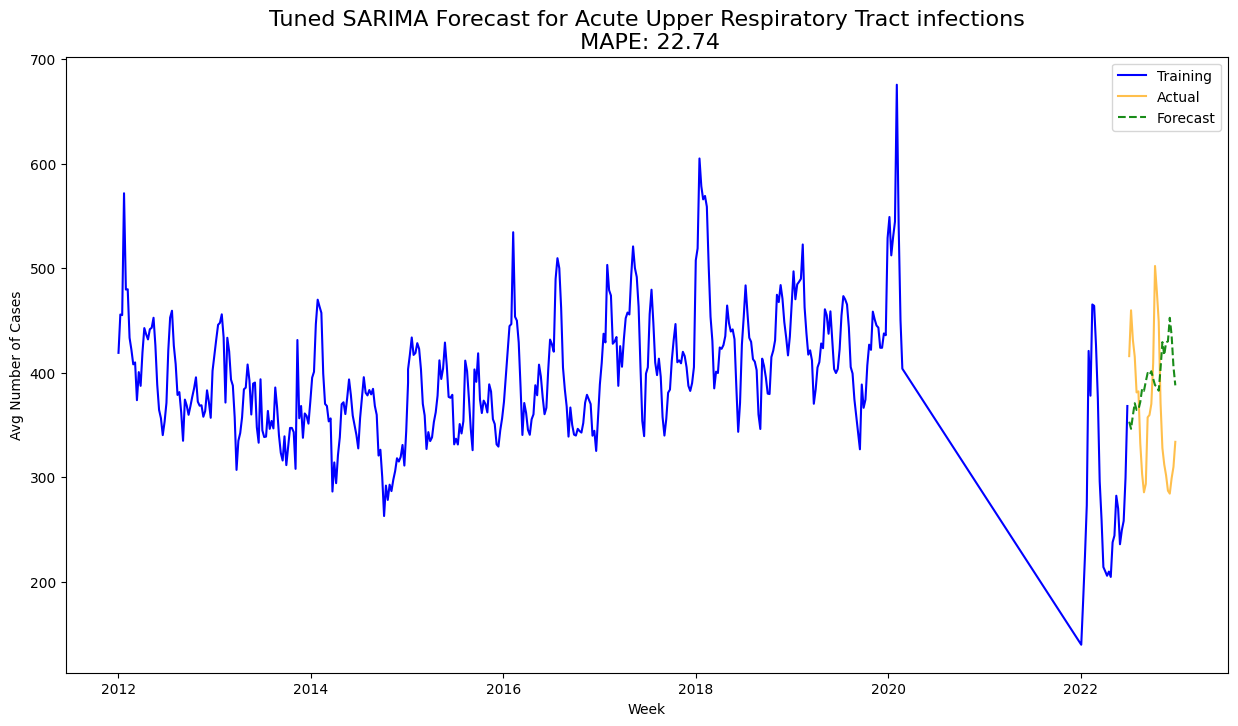

In [19]:
# Evaluation
for disease in acute_disease:
    sarima_mape = calculate_mape(test_data[disease], sarima_forecasts_rev[disease])
    print(f"{disease} - SARIMA MAPE: {sarima_mape:.2f}%")
    plot_forecast(train_data[disease], test_data[disease], sarima_forecasts_rev[disease], f'Tuned SARIMA Forecast for {disease}')

__Conclusions:__ 
- Removing pandemic period did not improve the model performance. The model with the pandemic period included had better forecast accuracy for the disease: "Acute Upper Respiratory Tract infections".

#### Deployment on Streamlit
We'll deploy the model with the least MAPE: `Acute Diarrhoea` on Streamlit for interactive forecasting.

In [20]:
# Specify the disease of interest for deployment
disease_of_interest = "Acute Diarrhoea"

# Check if the model for the specified disease exists and save it
if disease_of_interest in sarima_models:
    joblib.dump(sarima_models[disease_of_interest], f'sarima_model_{disease_of_interest}.pkl')
    print(f"SARIMA model for {disease_of_interest} saved successfully.")
else:
    print(f"SARIMA model for {disease_of_interest} not found.")

SARIMA model for Acute Diarrhoea saved successfully.


In [23]:
%%writefile app.py

import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Load the dataset
file_path = '../data/question2/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv'
df = pd.read_csv(file_path)

# Convert epi_week to datetime format
df['epi_week'] = pd.to_datetime(df['epi_week'] + '-1', format='%Y-W%W-%w')

# Create a new column for "average_cases" for modeling
df['average_cases'] = df['no._of_cases'] / 7

# Setting date column as index for time series
df.set_index('epi_week', inplace=True)
df.sort_index(inplace=True)

# Specify the disease of interest
disease_of_interest = 'Acute Diarrhoea'

# Filter for the disease of interest
df = df[df['disease'] == disease_of_interest]

# Load the SARIMA model for the specific disease
model = joblib.load(f'sarima_model_{disease_of_interest}.pkl')

# Streamlit app
st.title(f"Polyclinic Attendance Forecasting for {disease_of_interest}")

# Get the data for the disease of interest
disease_data = df['average_cases']

# Split data into training and testing sets based on week 26 of 2022
train_end_date = pd.to_datetime('2022-07-03')  # 2022-W26
train_data = disease_data[disease_data.index <= train_end_date]
test_data = disease_data[disease_data.index > train_end_date]

# Make predictions using the loaded model
forecast = model.predict(n_periods=len(test_data))

# Calculate MAPE
mape = mean_absolute_percentage_error(test_data, forecast)

# Plot the forecast vs actual
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(train_data.index, train_data, color='blue', label='Training')
ax.plot(test_data.index, test_data, color='orange', label='Actual', alpha=0.7)
ax.plot(test_data.index, forecast, color='green', label='Forecast', alpha=0.9, ls='--')
ax.set_title(f'{disease_of_interest} Forecast\nMAPE: {mape:.2f}', fontsize=16)
ax.set_xlabel('Week')
ax.set_ylabel('Avg Number of Cases')
ax.legend()
st.pyplot(fig)

Writing app.py
